In [3]:
import pybedtools as pbt
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import stats
import treeswift as ts
from Bio import SeqIO, Seq, motifs, Phylo
import re
import logomaker
from collections import defaultdict
import numpy as np
from os.path import exists

In [49]:
tree = Phylo.read('../data/metazoa_phylum.nwk', 'newick')
tree.ladderize()  # Flip branches so deeper clades are displayed at top

target_taxa = [i.name for i in tree.get_terminals()]
taxdict = {}
with open('../data/species_taxonomy.txt') as infile:
    for line in infile:
        line = [i.strip('\t').strip() for i in line.strip().split('|')][:-1]
        species = '_'.join(line[1].split(' '))
        lineage = [i.strip() for i in line[2].split(';')][:-1]
        taxdict[species] = lineage
for species, lineage in taxdict.items():
    for tax in target_taxa:
        if tax in lineage:
            taxdict[species] = tax
            break
        else:
            taxdict[species] = 'NA'

metadata_df = pd.read_csv('../data/parsed_metazoans.out', 
                          sep='\t', 
                          header=None, 
                          names=['species', 'genome', 'ftpdir', 'scaffold_n50', 'assembly_status']) \
                .drop(['ftpdir', 'genome'], axis=1)
metadata_df['genus'] = metadata_df['species'].apply(lambda x: x.split('_')[0])
metadata_df['taxonomy'] = metadata_df.species.apply(lambda x: taxdict.get(x, 'Other'))
sample_df = metadata_df.loc[metadata_df.assembly_status != 'Contig'] \
                         .groupby('genus') \
                         .sample(1) \
                         .reset_index()
print(metadata_df.head())
print(sample_df.loc[sample_df.species.str.startswith('Lat')])

                 species  scaffold_n50 assembly_status         genus  \
0     Abisara_bifasciata           464          Contig       Abisara   
1   Abrostola_tripartita      13645312      Chromosome     Abrostola   
2  Abscondita_terminalis       1220005        Scaffold    Abscondita   
3     Acanthaster_planci       1521119        Scaffold   Acanthaster   
4   Acanthisitta_chloris         64469        Scaffold  Acanthisitta   

        taxonomy  
0     Arthropoda  
1     Arthropoda  
2     Arthropoda  
3  Echinodermata  
4       Chordata  
      index                species  scaffold_n50 assembly_status        genus  \
1015   2042  Lateolabrax_maculatus      22343975      Chromosome  Lateolabrax   
1016   2043       Lates_calcarifer       1191366        Scaffold        Lates   
1017   2044    Laticauda_colubrina      39959644        Scaffold    Laticauda   
1018   2046    Latimeria_chalumnae        924513        Scaffold    Latimeria   
1019   2047   Latrodectus_hesperus         39474

In [50]:
znf_counts = []
for species in sample_df.iterrows():
    try:
        znf_bed = pbt.BedTool(f'../data/beds/{species[1].species}_znfs.bed')
    except:
        print(f'{species} missing')
    for row in znf_bed:
        znf_counts.append((species[1].species, species[1].taxonomy, int(row[4])))
znf_count_df = pd.DataFrame(znf_counts, columns=['species', 'taxonomy', 'znf_count'])
print(znf_count_df)
print(znf_count_df.loc[znf_count_df.species == 'Latimeria_chalumnae'])

(4, index                                     5
species            Acanthochaenus_luetkenii
scaffold_n50                           8444
assembly_status                    Scaffold
genus                        Acanthochaenus
taxonomy                           Chordata
Name: 4, dtype: object) missing
(9, index                         11
species            Acartia_tonsa
scaffold_n50                3610
assembly_status         Scaffold
genus                    Acartia
taxonomy              Arthropoda
Name: 9, dtype: object) missing
(12, index                                  16
species            Achipteria_coleoptrata
scaffold_n50                         7481
assembly_status                  Scaffold
genus                          Achipteria
taxonomy                       Arthropoda
Name: 12, dtype: object) missing
(14, index                                   22
species            Acipenser_transmontanus
scaffold_n50                          2601
assembly_status                   Scaffold

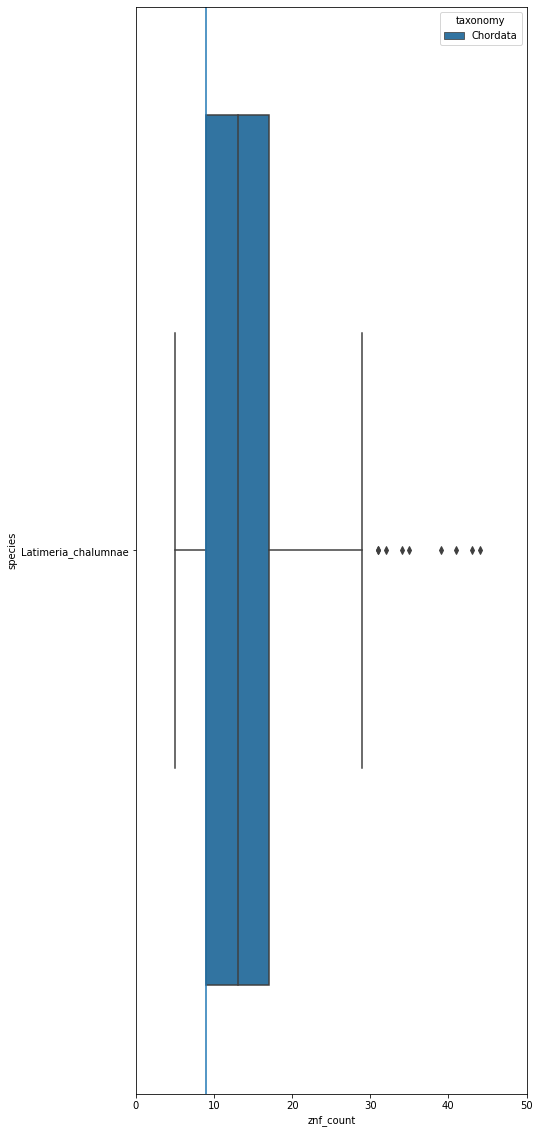

In [52]:
fig, ax = plt.subplots(figsize=(7, 20))
sns.boxplot(data=znf_count_df.loc[znf_count_df.species == 'Latimeria_chalumnae'], y='species', x='znf_count', hue='taxonomy', ax=ax, dodge=False)
# ax.set_xscale('log')
ax.set_xlim(0, 50)
ax.axvline(znf_count_df.znf_count.median())
plt.show()

In [14]:
def extract_znf(species):
    znfs = []
    for record in SeqIO.parse(f'../data/seqs/{species}_znfs.fa', 'fasta'):
        znfs += re.findall('C..C.{12}H...H', str(record.seq.translate()))
    return znfs

def extract_footprints(species):
    footprints = []
    for record in SeqIO.parse(f'../data/seqs/{species}_znfs.fa', 'fasta'):
        footprints += re.findall('C..C.{12}H...H', str(record.seq.translate()))
    footprints = [f'{i[9]}{i[11]}{i[12]}{i[15]}' for i in footprints]
    return footprints

def entropy(position):
    return -sum(position.apply(lambda x: x*np.log2(x)))

/Users/jonwells/miniconda3/envs/python_env/lib/python3.9/site-packages/Bio/Seq.py:2979: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(


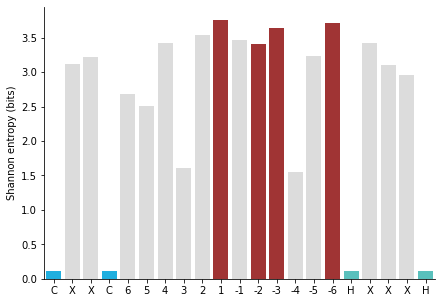

In [17]:
znfs = []
for row in metadata_df.loc[metadata_df.taxonomy == 'Ctenophora'].iterrows():
    if row[1].scaffold_n50 >= 10000:
        znfs += extract_znf(row[1].species)
mat_df = logomaker.alignment_to_matrix(znfs, to_type='probability').T
data = defaultdict(list)
for col in mat_df.columns:
    data['position'].append(col)
    data['entropy'].append(entropy(mat_df[col]))
    
znf_df = pd.DataFrame(data)
znf_df['pos_labels'] = ['C', 'X', 'X', 'C', 6, 5, 4, 3, 2, 1, -1, -2, -3, -4, -5, -6, 'H', 'X', 'X', 'X', 'H']
znf_df['colours'] = ['deepskyblue', 'gainsboro', 'gainsboro', 'deepskyblue', 
                     'gainsboro', 'gainsboro', 'gainsboro', 'gainsboro', 'gainsboro', 'firebrick',
                     'gainsboro', 'firebrick', 'firebrick', 'gainsboro', 'gainsboro', 'firebrick',
                     'mediumturquoise', 'gainsboro', 'gainsboro', 'gainsboro', 'mediumturquoise'] 

fig, ax = plt.subplots(figsize=(7, 5))
sns.barplot(data=znf_df, x='position', y='entropy', palette=znf_df.colours)
ax.set_xlabel('')
ax.set_ylabel('Shannon entropy (bits)')
ax.set_xticklabels(znf_df.pos_labels)
sns.despine()
plt.show()



In [51]:
for sp in set(znf_count_df.loc[znf_count_df.species.str.startswith('Latimeria'), 'species']):
    try:
        fp_freq = defaultdict(int)
        all_fps = extract_footprints(sp)
        for fp in all_fps:
            fp_freq[fp] += 1
        tot = sum(v for v in fp_freq.values())
    
        count = znf_count_df.loc[znf_count_df.species == sp, 'znf_count'].sum()

        print(f'{sp:30}', f'{str(len(fp_freq)):10}', count, f'{tot/count:.2f}')
#         # for k, v in sorted(fp_freq.items(), key=lambda x: -x[1])[:10]:
#         #     print(k, 100*v/tot)
    except:
        print(f'{sp} missing')


Latimeria_chalumnae            2470       6029 0.78


/Users/jonwells/miniconda3/envs/python_env/lib/python3.9/site-packages/Bio/Seq.py:2979: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(


In [59]:
with open('/Users/jonwells/Desktop/danio_rerio_motifs_shuffled_full.fa', 'w') as outfile:
    with open('/Users/jonwells/Desktop/danio_rerio_pfm.txt') as handle:
        for m in motifs.parse(handle, 'ClusterBuster'):
            cons = m.consensus
            if len(cons) < 12:
                continue
            cons = [c for c in cons]
            np.random.shuffle(cons)
            cons = ''.join(cons)
            # cons = ''.join([np.random.choice(['C', 'G']*36 + ['A', 'T']*64) for i in range(12)])
            # windows = set()
            # for i in range(len(cons) - 11):
            #     windows.add(cons[i:i+12])
            # for i, val in enumerate(windows):
            outfile.write(f'>{m.name}\n{cons}\n')

In [9]:
print(metadata_df.loc[metadata_df.species.str.startswith('Biomphalaria')])

                   species  scaffold_n50 assembly_status         genus  \
506  Biomphalaria_glabrata         48059        Scaffold  Biomphalaria   

     taxonomy  
506  Mollusca  
